# Estimating 3D generation performance

This is a codebook describing the process of estimation of MACE's 3D generation performance. Long story short, we extracted more than 2000 of multidentate ligands found in octahedral and square-planar metal complexes from [Cambridge Structural Database](https://www.ccdc.cam.ac.uk/) and used them as input to the MACE-based pipeline generating possible stereomers and their 3D atomic coordinates.

## Methods

### Getting complexes

CSD version 5.43 (Nov 2021) was used to get entries containing 6-coordinated Ru or Mn complexes and 4-coordinated Pt complexes, which were saved in the [SMILES](ligands/csd) format.

### Preparing ligands

Obtained entries were used to extract multidentate ligands [extract_ligands.py](ligands/extract_ligands.py). All entries were splitted to the residues, and those that fell under the concept of a mononuclear 4/6-coordinated metal complex were selected. Next, those complexes were separated into ligands and a central atom, and polydentate organic ligands (restricted to H, B, C, N, O, F, Si, P, S, Cl, As, Se, Br, I elements) were picked for the MACE computations ([csd_ligands.csv](ligands/cleared_ligands/csd_ligands.csv). 8 ligands for which RDKit filed to generate 3D geometry were not considered [no3D_ligands.txt](ligands/cleared_ligands/no3D_ligands.txt). Structures of selected [octahedral](ligands/cleared_ligands/OH) and [square-planar](ligands/cleared_ligands/SP) ligands were visualized and saved in the `PNG` format.

### Generating 3D coordinates

Selected ligands were used to test MACE's 3D generation performance [brute_force.py](brute_force.py). For each ligand, a complex was generated consisting of the selected ligand, `6-denticity`/`4-denticity` CO ligands, and `Ru`/`Pt` as central atom for octahedral and square-planar geometries respectively. After that, a search for stereomers was carried out followed by generation of conformers. Results of MACE performance (generation time, number of 3D generation errors) were saved to [OH_CO.csv](outputs/logs/OH_CO.csv) and [SP_CO.csv](outputs/logs/SP_CO.csv). Structures of successfully generated complexes can be found in [OH_CO](outputs/OH_CO) and [SP_CO](outputs/SP_CO) directories.

## Results

MACE failed to generate geometry for 7 complexes out of 2178:

In [1]:
import pandas as pd

# prepare data
OH = pd.read_csv('outputs/logs/OH_CO.csv')
SP = pd.read_csv('outputs/logs/SP_CO.csv')
OH.insert(0, 'geom', 'OH')
SP.insert(0, 'geom', 'SP')
df = pd.concat([OH, SP], ignore_index = True)
df

,geom,complex,n,success,no3D,error,time
0,OH,OH0,2,1,0,0,0.8
1,OH,OH1,3,1,0,0,2.0
2,OH,OH2,5,2,0,0,2.4
3,OH,OH3,2,1,0,0,2.8
4,OH,OH4,4,3,0,0,13.1
...,...,...,...,...,...,...,...
2173,SP,SP664,2,1,0,0,0.7
2174,SP,SP665,2,2,0,0,395.3
2175,SP,SP666,4,1,0,0,0.9
2176,SP,SP667,2,1,0,0,0.6


In [2]:
# get number of ligands with various denticity
pd.pivot_table(data = df[['geom','n']], index = 'n', columns = 'geom', aggfunc = lambda x: x.size)

geom,OH,SP
n,,
2,1512.0,982.0
3,860.0,116.0
4,386.0,240.0
5,152.0,NaN
6,108.0,NaN


In [3]:
sum(df.error != 0)

0

In [4]:
df.loc[df.no3D != 0]

,geom,complex,n,success,no3D,error,time
76,OH,OH76,5,1,1,0,115.2
77,OH,OH77,5,1,1,0,99.4
239,OH,OH239,5,1,1,0,38.9
245,OH,OH245,3,1,1,0,5.1
347,OH,OH347,3,1,1,0,10.4
378,OH,OH378,3,1,1,0,5.4
1065,OH,OH1065,3,0,1,0,88.8


For 6 of those systems 3D generation failed for 1 of 2 found stereomers. A careful analysis of their structure shows that only one spatial arrangement of donor atoms is expected for the ligands. Therefore, only one complex failed to be generated:

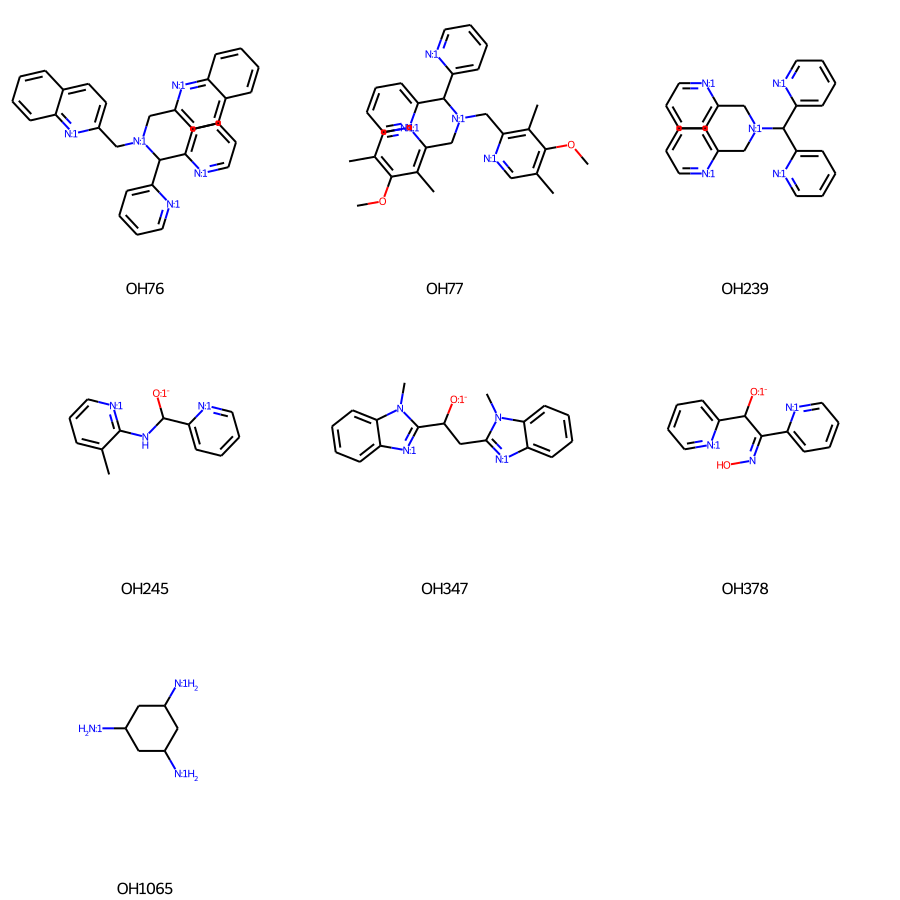

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw

ligands = pd.read_csv('ligands/cleared_ligands/csd_ligands.csv')
no3D = ligands.loc[ligands['id'].isin(df.loc[df.no3D != 0,'complex']), ['id','smiles']]

mols = [Chem.MolFromSmiles(smi) for smi in no3D.smiles]
legends = [_ for _ in no3D['id']]
Draw.MolsToGridImage(mols = mols, legends = legends, subImgSize = (300, 300))

Summing up, the absence of conformers in MACE output should be considered as a sign of highly unstable complex geometry and can be ignored in massive computational pipelines.

3D geometry of 90% of the considered complexes was generated in less than 5 seconds. The maximum processing time is about half an hour. Median time increases slowly from 1s for 2-dentate to 2.5 s for 6-dentate systems:

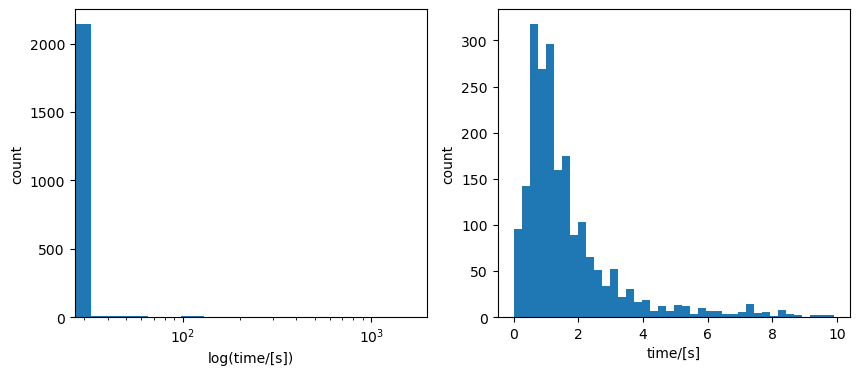

< 1 s for 37.9% of systems
< 5 s for 90.1% of systems
< 10 s for 95.0% of systems


In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
axes[0].hist(df.time, bins = 50)
axes[0].set_xscale('log')
axes[0].set_xlabel('log(time/[s])')
axes[0].set_ylabel('count')
axes[1].hist(df.time.loc[df.time < 10], bins = 40)
axes[1].set_xlabel('time/[s]')
axes[1].set_ylabel('count')
plt.show()

for dt in (1,5,10):
    print(f'< {dt} s for {100*(df.time < dt).mean():.1f}% of systems')

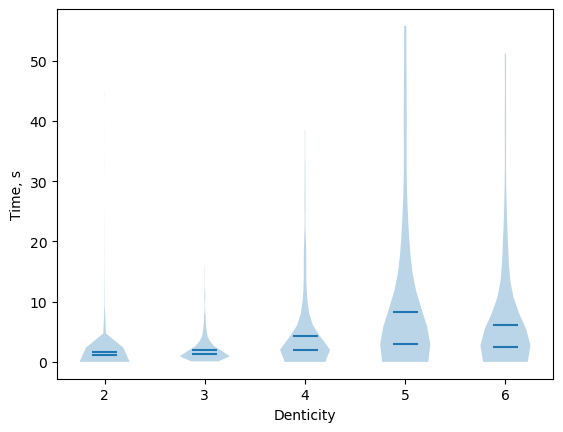

In [7]:
data = {n: df.loc[(df.time < 60) & (df.n == n), 'time'].values for n in set(df.n)}
fig, ax = plt.subplots()
ax.violinplot(data.values(), data.keys(), points = 20, widths=0.5,
              showmeans = True, showextrema = False, showmedians = True)
ax.set_xlabel('Denticity')
ax.set_ylabel('Time, s')
plt.show()

Given that all calculations were carried out on a typical office computer on one core, we conclude that MACE's performance is sufficient to build computational pipelines.